# **log**

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


# **Prepare**

In [2]:
!pip install transformers
'''!pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu116
!pip install nltk
!pip install Keras-Preprocessing'''
# Importing the libraries needed
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import os
import math
import torch
import seaborn as sns
import transformers
import json
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaModel, RobertaTokenizer

import warnings
warnings.filterwarnings('ignore')
import logging
logging.getLogger("transformers.tokenization_utils_base").setLevel(logging.ERROR)

import matplotlib.pyplot as plt
import tensorflow as tf
from transformers import BertTokenizer
from transformers import DistilBertTokenizer, RobertaTokenizer
from tensorflow.keras.optimizers import Adam, SGD
from transformers import TFXLNetModel, XLNetTokenizer
import nltk
import re
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from numpy import array
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from tensorflow.keras.layers import Embedding
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers import Concatenate
from torch.nn import BCEWithLogitsLoss
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW, XLNetTokenizer, XLNetModel, XLNetLMHeadModel, XLNetConfig
from tqdm import tqdm, trange


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 70.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 97.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 21.6 MB/s eta 0:00:00


In [3]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [4]:

train = pd.read_csv("/content/gdrive/MyDrive/5800/train.scruples-anecdotes.csv" ,skip_blank_lines=True)

dev =pd.read_csv("/content/gdrive/MyDrive/5800/dev-scruples-anecdotes.csv", skip_blank_lines=True)

test =pd.read_csv("/content/gdrive/MyDrive/5800/test.scruples-anecdotes.csv", skip_blank_lines=True)



In [5]:
train.shape

(27766, 10)

In [6]:
train

,id,post_id,action,title,text,post_type,label_scores,label,binarized_label_scores,binarized_label
0,yqk9ZSYu3Vd9A6sUBIGPLJ0mTCxcsv74,ar2iqw,"{'description': 'hiding my controller', 'prono...",AITA for hiding my controller?,"Backstory: So, I got an Xbox one for Christmas...",HISTORICAL,"{'AUTHOR': 0, 'OTHER': 22, 'EVERYBODY': 0, 'NO...",4,"{'RIGHT': 22, 'WRONG': 0}",RIGHT
1,xBCLN7LVJBGNAakxDVBy0fOrtpfTE577,aqtrol,"{'description': 'ratting out my supervisor', '...",AITA For Ratting Out My Supervisor?,I work with about six other people at might jo...,HISTORICAL,"{'AUTHOR': 0, 'OTHER': 5, 'EVERYBODY': 0, 'NOB...",4,"{'RIGHT': 5, 'WRONG': 0}",RIGHT
2,IdwLUU6ucUJfK8pL1Uv82dQpPVvgppO8,b01ajb,{'description': 'commenting that unfamiliar in...,AITA for commenting that unfamiliar indie band...,Context: There was an Instagram post about unp...,HISTORICAL,"{'AUTHOR': 3, 'OTHER': 4, 'EVERYBODY': 0, 'NOB...",4,"{'RIGHT': 5, 'WRONG': 3}",RIGHT
3,pbFtHLhjFcEF0MpceVPvk4oGmQeKof8D,a4m4zq,{'description': 'arguing for my friend to surr...,AITA for arguing for my Friend to Surrender in...,Me and my friends spent sometime organizing a ...,HISTORICAL,"{'AUTHOR': 5, 'OTHER': 0, 'EVERYBODY': 0, 'NOB...",0,"{'RIGHT': 0, 'WRONG': 5}",WRONG
4,IZzCnvsXj8vBAhArM0gxgALAwrd50yHG,apna7l,{'description': 'being mad at my wife for negl...,AITA for being mad at my wife for neglecting/ ...,A little background. I'm a far from rich guy w...,HISTORICAL,"{'AUTHOR': 0, 'OTHER': 5, 'EVERYBODY': 4, 'NOB...",4,"{'RIGHT': 5, 'WRONG': 4}",RIGHT
...,...,...,...,...,...,...,...,...,...,...
27761,MsxMg8eUAk7L2DuE1AT4IlwMzXZ90rUP,amjxh1,{'description': 'getting mad at my girlfriend ...,AITA for getting mad at my girlfriend for dism...,So a bit of background info. My girlfriend has...,HISTORICAL,"{'AUTHOR': 0, 'OTHER': 1, 'EVERYBODY': 1, 'NOB...",4,"{'RIGHT': 1, 'WRONG': 1}",RIGHT
27762,OYJdH0Swn7PxoOD3XfKdOtotoHLgMRvN,amuw37,"{'description': ""feeling shitty my best friend...",AITA for feeling shitty my best friend didn’t ...,Context:\n\nI’ve been best friends with this g...,HISTORICAL,"{'AUTHOR': 0, 'OTHER': 1, 'EVERYBODY': 0, 'NOB...",4,"{'RIGHT': 2, 'WRONG': 0}",RIGHT
27763,XOamt7UoD9nOsnQjNUWfsKx4jdGV708h,ajta6b,{'description': 'commenting on how my gf and h...,AITA for commenting on how my gf and her mum a...,So me (19M) and my gf’s (18F) relationship has...,HISTORICAL,"{'AUTHOR': 1, 'OTHER': 1, 'EVERYBODY': 0, 'NOB...",0,"{'RIGHT': 2, 'WRONG': 1}",RIGHT
27764,FJ2u1Tojs9VtXH52bb1iLBAdP6WYn3Yt,b0cdwc,{'description': 'missing out on family events ...,AITA for missing out on family events to work ...,"A little info, I’m an Early College student, f...",HISTORICAL,"{'AUTHOR': 1, 'OTHER': 1, 'EVERYBODY': 0, 'NOB...",3,"{'RIGHT': 3, 'WRONG': 1}",RIGHT


In [7]:
print(train['text'].isnull().sum())
print(dev['text'].isnull().sum())
print(test['text'].isnull().sum())

22
1
4


In [8]:
train = train.dropna()
dev = dev.dropna()
test = test.dropna()

In [9]:
print(train['text'].isnull().sum())
print(dev['text'].isnull().sum())
print(test['text'].isnull().sum())

0
0
0


In [10]:
train_df = train[['text', 'binarized_label']]

In [11]:
dev_df = dev[['text','binarized_label']]

In [12]:
test_df =  test[['text','binarized_label']]

In [13]:
dev_df

,text,binarized_label
0,My boyfriend (well just call him M) and I are ...,RIGHT
2,\n\nMy really good friend is getting married....,RIGHT
3,"I've been very lonely for a long time, few fri...",RIGHT
4,Alt account because friends know my real one. ...,RIGHT
5,Pretty much was hanging out with two friends. ...,WRONG
...,...,...
2494,For reference we're both juniors at a T20 coll...,WRONG
2495,So this just happened and I'm a little taken a...,WRONG
2497,"So, I've been friends with someone for a few y...",RIGHT
2498,My first post!\n\nNo words were exchanged in t...,RIGHT


In [14]:
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder

label_encoder = preprocessing.LabelEncoder()

train_df['num_binarized_label']= label_encoder.fit_transform(train_df['binarized_label'])
dev_df['num_binarized_label']= label_encoder.fit_transform(dev_df['binarized_label'])
test_df['num_binarized_label']= label_encoder.fit_transform(test_df['binarized_label'])


In [15]:
train_df

,text,binarized_label,num_binarized_label
0,"Backstory: So, I got an Xbox one for Christmas...",RIGHT,0
1,I work with about six other people at might jo...,RIGHT,0
2,Context: There was an Instagram post about unp...,RIGHT,0
3,Me and my friends spent sometime organizing a ...,WRONG,1
4,A little background. I'm a far from rich guy w...,RIGHT,0
...,...,...,...
27761,So a bit of background info. My girlfriend has...,RIGHT,0
27762,Context:\n\nI’ve been best friends with this g...,RIGHT,0
27763,So me (19M) and my gf’s (18F) relationship has...,RIGHT,0
27764,"A little info, I’m an Early College student, f...",RIGHT,0


In [16]:
train_df

,text,binarized_label,num_binarized_label
0,"Backstory: So, I got an Xbox one for Christmas...",RIGHT,0
1,I work with about six other people at might jo...,RIGHT,0
2,Context: There was an Instagram post about unp...,RIGHT,0
3,Me and my friends spent sometime organizing a ...,WRONG,1
4,A little background. I'm a far from rich guy w...,RIGHT,0
...,...,...,...
27761,So a bit of background info. My girlfriend has...,RIGHT,0
27762,Context:\n\nI’ve been best friends with this g...,RIGHT,0
27763,So me (19M) and my gf’s (18F) relationship has...,RIGHT,0
27764,"A little info, I’m an Early College student, f...",RIGHT,0


In [17]:
def clean_text(text):
    #Remove emojis and special chars
    clean=text
    #reg = re.compile('\\.+?(?=\B|$)')
    #clean = text.apply(lambda r: re.sub(reg, string=r, repl=''))
    #reg = re.compile('\x89Û_')
    #clean = clean.apply(lambda r: re.sub(reg, string=r, repl=' '))
    reg = re.compile('\&amp')
    clean = clean.apply(lambda r: re.sub(reg, string=r, repl='&'))
    reg = re.compile('\\n')
    clean = clean.apply(lambda r: re.sub(reg, string=r, repl=' '))
    
    #Remove hashtag symbol (#)
    #clean = clean.apply(lambda r: r.replace('#', ''))

    #Remove user names
    reg = re.compile('@[a-zA-Z0-9\_]+')
    clean = clean.apply(lambda r: re.sub(reg, string=r, repl='@'))

    #Remove URLs
    reg = re.compile('https?\S+(?=\s|$)')
    clean = clean.apply(lambda r: re.sub(reg, string=r, repl='www'))

    #Lowercase
    #clean = clean.apply(lambda r: r.lower())
    return clean

In [18]:
train_df = train_df.replace(np.nan, '', regex=True)

dev_df = dev_df.replace(np.nan, '', regex=True)

test_df = test_df.replace(np.nan, '', regex=True)


In [19]:
#toxic_df['clean'] = clean_text(toxic_df['comment_text'])
train_df['clean'] = clean_text(train_df['text'])
dev_df['clean'] = clean_text(dev_df['text'])
test_df['clean'] = clean_text(test_df['text'])

In [20]:
train_df

,text,binarized_label,num_binarized_label,clean
0,"Backstory: So, I got an Xbox one for Christmas...",RIGHT,0,"Backstory: So, I got an Xbox one for Christmas..."
1,I work with about six other people at might jo...,RIGHT,0,I work with about six other people at might jo...
2,Context: There was an Instagram post about unp...,RIGHT,0,Context: There was an Instagram post about unp...
3,Me and my friends spent sometime organizing a ...,WRONG,1,Me and my friends spent sometime organizing a ...
4,A little background. I'm a far from rich guy w...,RIGHT,0,A little background. I'm a far from rich guy w...
...,...,...,...,...
27761,So a bit of background info. My girlfriend has...,RIGHT,0,So a bit of background info. My girlfriend has...
27762,Context:\n\nI’ve been best friends with this g...,RIGHT,0,Context: I’ve been best friends with this guy...
27763,So me (19M) and my gf’s (18F) relationship has...,RIGHT,0,So me (19M) and my gf’s (18F) relationship has...
27764,"A little info, I’m an Early College student, f...",RIGHT,0,"A little info, I’m an Early College student, f..."


In [21]:
test_df['clean'][0]

"   Throwaway for obvious reasons.     I dropped out of uni 2 years ago because I was planning on moving to a different country and going to Uni there. However, my parents didn't want to help me in any way and I couldn't afford it myself. They've always supported my younger sister though, bought her an apartment and they're even paying her bills, even though she earns enough money to do that herself. So atm I'm stuck at home with them, which sucks as I am 25 yo and I feel like I'm wasting my life completely.     Both my parents were extremely abusive, especially my dad. As a result, I have social anxiety, trust issues, panic attacks etc. I can deal with everything as I got used to it anyway, but lately things have gotten worse.     A few years ago my dad was diagnosed with type II diabetes, and he retired. He's been staying at home ever since and he's slowly but surely becoming a vegetable. He had a stroke which left him unable to speak/walk properly. I'm no doctor, but I found his hos

# **Data preprocessing**

In [22]:
#toxic_df["lower"] = toxic_df["clean"].apply(lambda x: x.lower())

train_df["lower"] = train_df["clean"].apply(lambda x: x.lower())

dev_df["lower"] = dev_df["clean"].apply(lambda x: x.lower())

test_df["lower"] = test_df["clean"].apply(lambda x: x.lower())
display(train_df.head())

,text,binarized_label,num_binarized_label,clean,lower
0,"Backstory: So, I got an Xbox one for Christmas...",RIGHT,0,"Backstory: So, I got an Xbox one for Christmas...","backstory: so, i got an xbox one for christmas..."
1,I work with about six other people at might jo...,RIGHT,0,I work with about six other people at might jo...,i work with about six other people at might jo...
2,Context: There was an Instagram post about unp...,RIGHT,0,Context: There was an Instagram post about unp...,context: there was an instagram post about unp...
3,Me and my friends spent sometime organizing a ...,WRONG,1,Me and my friends spent sometime organizing a ...,me and my friends spent sometime organizing a ...
4,A little background. I'm a far from rich guy w...,RIGHT,0,A little background. I'm a far from rich guy w...,a little background. i'm a far from rich guy w...


In [23]:
!pip install contractions
import contractions
#toxic_df["lower"] = toxic_df["lower"].apply(lambda x: contractions.fix(x))
train_df["lower"] = train_df["lower"].apply(lambda x: contractions.fix(x))
dev_df["lower"] = dev_df["lower"].apply(lambda x: contractions.fix(x))
test_df["lower"] = test_df["lower"].apply(lambda x: contractions.fix(x))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.5/104.5 KB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.5/287.5 KB 19.3 MB/s eta 0:00:00


In [24]:
def remove_non_ascii(text):
    """
        Remove non-ASCII characters 
    """
    return re.sub(r'[^\x00-\x7f]',r'', text) # or ''.join([x for x in text if x in string.printable]) 

# remove non-ascii characters from the text
#toxic_df["lower"] = toxic_df["lower"].apply(lambda x: remove_non_ascii(x))
train_df["lower"] = train_df["lower"].apply(lambda x: remove_non_ascii(x))
dev_df["lower"] = dev_df["lower"].apply(lambda x: remove_non_ascii(x))
test_df["lower"] = test_df["lower"].apply(lambda x: remove_non_ascii(x))

In [25]:
def remove_special_characters(text):
    """
        Remove special special characters, including symbols, emojis, and other graphic characters
    """
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


# remove non-ascii characters from the text
#toxic_df["lower"] = toxic_df["lower"].apply(lambda x: remove_special_characters(x))
train_df["lower"] = train_df["lower"].apply(lambda x: remove_special_characters(x))
dev_df["lower"] = dev_df["lower"].apply(lambda x: remove_special_characters(x))
test_df["lower"] = test_df["lower"].apply(lambda x: remove_special_characters(x))

In [26]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [27]:
# Tokenizing the tweet base texts.
from nltk.tokenize import word_tokenize
#toxic_df['tokenized'] = toxic_df['lower'].apply(word_tokenize)
train_df['tokenized'] = train_df['lower'].apply(word_tokenize)
dev_df['tokenized'] = dev_df['lower'].apply(word_tokenize)
test_df['tokenized'] = test_df['lower'].apply(word_tokenize)

In [28]:
from nltk.stem import SnowballStemmer

def snowball_stemmer(text):
    """
        Stem words in list of tokenized words with SnowballStemmer
    """
    stemmer = nltk.SnowballStemmer("english")
    stems = [stemmer.stem(i) for i in text]
    return stems



In [29]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [30]:
from nltk.stem import WordNetLemmatizer

def lemmatize_word(text):
    """
        Lemmatize the tokenized words
    """

    lemmatizer = WordNetLemmatizer()
    lemma = [lemmatizer.lemmatize(word, tag) for word, tag in text]
    return lemma



lemmatizer = WordNetLemmatizer()

#toxic_df['lemmatize_word_wo_pos'] = toxic_df['tokenized'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

train_df['lemmatize_word_wo_pos'] = train_df['tokenized'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
#train_df['lemmatize_word_wo_pos'] = train_df['lemmatize_word_wo_pos'].apply(lambda x: [word for word in x if word not in stop])

dev_df['lemmatize_word_wo_pos'] = dev_df['tokenized'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
#dev_df['lemmatize_word_wo_pos'] = dev_df['lemmatize_word_wo_pos'].apply(lambda x: [word for word in x if word not in stop])

test_df['lemmatize_word_wo_pos'] = test_df['tokenized'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
#test_df['lemmatize_word_wo_pos'] = test_df['lemmatize_word_wo_pos'].apply(lambda x: [word for word in x if word not in stop])

In [31]:
connect1 = []
for i in train_df['lemmatize_word_wo_pos']:
  connect1.append(' '.join(i))
train_df['clean1'] = connect1


connect2 = []
for i in dev_df['lemmatize_word_wo_pos']:
  connect2.append(' '.join(i))
dev_df['clean1'] = connect2


connect3 = []
for i in test_df['lemmatize_word_wo_pos']:
  connect3.append(' '.join(i))
test_df['clean1'] = connect3


In [32]:
dev_df['clean'][0]

'My boyfriend (well just call him M) and I are creators on Instagram (he is also on TikTok). I\'m a digital and traditional artist and in one of my classes we create t shirts and things (socks, lanyards, water bottles, stickers, you name it). I\'m a big fan of putting my art on t shirts so I can sell them.  M wanted to make some posts for TikTok and wanted to use the shirt I made today. My one personal rule is that if the shirt isn\'t being given to someone else, then I wear it first (this is because I know I wont get it back. Ive made one other shirt that I\'ve worn, and he wore it for a week and hasn\'t given it back.) So I told him no, because I haven\'t worn the shirt yet.   M proceeded to complain about not having content to post, and how his IG post today didn\'t get any engagement, saying "of course you dont know, because you never look."  Am I the asshole for wanting to wear the shirt I made just once?'

In [33]:
dev_df

,text,binarized_label,num_binarized_label,clean,lower,tokenized,lemmatize_word_wo_pos,clean1
0,My boyfriend (well just call him M) and I are ...,RIGHT,0,My boyfriend (well just call him M) and I are ...,my boyfriend (well just call him m) and i are ...,"[my, boyfriend, (, well, just, call, him, m, )...","[my, boyfriend, (, well, just, call, him, m, )...",my boyfriend ( well just call him m ) and i ar...
2,\n\nMy really good friend is getting married....,RIGHT,0,My really good friend is getting married. Y...,my really good friend is getting married. y...,"[my, really, good, friend, is, getting, marrie...","[my, really, good, friend, is, getting, marrie...",my really good friend is getting married . yay...
3,"I've been very lonely for a long time, few fri...",RIGHT,0,"I've been very lonely for a long time, few fri...","i have been very lonely for a long time, few f...","[i, have, been, very, lonely, for, a, long, ti...","[i, have, been, very, lonely, for, a, long, ti...","i have been very lonely for a long time , few ..."
4,Alt account because friends know my real one. ...,RIGHT,0,Alt account because friends know my real one. ...,alt account because friends know my real one. ...,"[alt, account, because, friends, know, my, rea...","[alt, account, because, friend, know, my, real...",alt account because friend know my real one . ...
5,Pretty much was hanging out with two friends. ...,WRONG,1,Pretty much was hanging out with two friends. ...,pretty much was hanging out with two friends. ...,"[pretty, much, was, hanging, out, with, two, f...","[pretty, much, wa, hanging, out, with, two, fr...",pretty much wa hanging out with two friend . i...
...,...,...,...,...,...,...,...,...
2494,For reference we're both juniors at a T20 coll...,WRONG,1,For reference we're both juniors at a T20 coll...,for reference we are both juniors at a t20 col...,"[for, reference, we, are, both, juniors, at, a...","[for, reference, we, are, both, junior, at, a,...",for reference we are both junior at a t20 coll...
2495,So this just happened and I'm a little taken a...,WRONG,1,So this just happened and I'm a little taken a...,so this just happened and i am a little taken ...,"[so, this, just, happened, and, i, am, a, litt...","[so, this, just, happened, and, i, am, a, litt...",so this just happened and i am a little taken ...
2497,"So, I've been friends with someone for a few y...",RIGHT,0,"So, I've been friends with someone for a few y...","so, i have been friends with someone for a few...","[so, ,, i, have, been, friends, with, someone,...","[so, ,, i, have, been, friend, with, someone, ...","so , i have been friend with someone for a few..."
2498,My first post!\n\nNo words were exchanged in t...,RIGHT,0,My first post! No words were exchanged in thi...,my first post! no words were exchanged in thi...,"[my, first, post, !, no, words, were, exchange...","[my, first, post, !, no, word, were, exchanged...",my first post ! no word were exchanged in this...


In [34]:
train_df

,text,binarized_label,num_binarized_label,clean,lower,tokenized,lemmatize_word_wo_pos,clean1
0,"Backstory: So, I got an Xbox one for Christmas...",RIGHT,0,"Backstory: So, I got an Xbox one for Christmas...","backstory: so, i got an xbox one for christmas...","[backstory, :, so, ,, i, got, an, xbox, one, f...","[backstory, :, so, ,, i, got, an, xbox, one, f...","backstory : so , i got an xbox one for christm..."
1,I work with about six other people at might jo...,RIGHT,0,I work with about six other people at might jo...,i work with about six other people at might jo...,"[i, work, with, about, six, other, people, at,...","[i, work, with, about, six, other, people, at,...",i work with about six other people at might jo...
2,Context: There was an Instagram post about unp...,RIGHT,0,Context: There was an Instagram post about unp...,context: there was an instagram post about unp...,"[context, :, there, was, an, instagram, post, ...","[context, :, there, wa, an, instagram, post, a...",context : there wa an instagram post about unp...
3,Me and my friends spent sometime organizing a ...,WRONG,1,Me and my friends spent sometime organizing a ...,me and my friends spent sometime organizing a ...,"[me, and, my, friends, spent, sometime, organi...","[me, and, my, friend, spent, sometime, organiz...",me and my friend spent sometime organizing a g...
4,A little background. I'm a far from rich guy w...,RIGHT,0,A little background. I'm a far from rich guy w...,a little background. i am a far from rich guy ...,"[a, little, background, ., i, am, a, far, from...","[a, little, background, ., i, am, a, far, from...",a little background . i am a far from rich guy...
...,...,...,...,...,...,...,...,...
27761,So a bit of background info. My girlfriend has...,RIGHT,0,So a bit of background info. My girlfriend has...,so a bit of background info. my girlfriend has...,"[so, a, bit, of, background, info, ., my, girl...","[so, a, bit, of, background, info, ., my, girl...",so a bit of background info . my girlfriend ha...
27762,Context:\n\nI’ve been best friends with this g...,RIGHT,0,Context: I’ve been best friends with this guy...,context: i have been best friends with this g...,"[context, :, i, have, been, best, friends, wit...","[context, :, i, have, been, best, friend, with...",context : i have been best friend with this gu...
27763,So me (19M) and my gf’s (18F) relationship has...,RIGHT,0,So me (19M) and my gf’s (18F) relationship has...,so me (19m) and my gfs (18f) relationship has ...,"[so, me, (, 19m, ), and, my, gfs, (, 18f, ), r...","[so, me, (, 19m, ), and, my, gfs, (, 18f, ), r...",so me ( 19m ) and my gfs ( 18f ) relationship ...
27764,"A little info, I’m an Early College student, f...",RIGHT,0,"A little info, I’m an Early College student, f...","a little info, i am an early college student, ...","[a, little, info, ,, i, am, an, early, college...","[a, little, info, ,, i, am, an, early, college...","a little info , i am an early college student ..."


# **DistilBert**

In [35]:
#https://www.kaggle.com/code/madz2000/sentiment-analysis-cleaning-eda-bert-88-acc#BERT-WORKING#
import torch
import transformers as ppb # pytorch transformers

In [36]:
from tokenizers import BertWordPieceTokenizer
# First load the real tokenizer
tokenizer = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-uncased' , lower = True)
# Save the loaded tokenizer locally
tokenizer.save_pretrained('.')
# Reload it with the huggingface tokenizers library
fast_tokenizer = BertWordPieceTokenizer('vocab.txt', lowercase=True)
fast_tokenizer



Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Tokenizer(vocabulary_size=30522, model=BertWordPiece, unk_token=[UNK], sep_token=[SEP], cls_token=[CLS], pad_token=[PAD], mask_token=[MASK], clean_text=True, handle_chinese_chars=True, strip_accents=None, lowercase=True, wordpieces_prefix=##)

In [37]:
def fast_encode(texts, tokenizer, chunk_size=256, maxlen=1024):

    tokenizer.enable_truncation(max_length=maxlen)
    tokenizer.enable_padding()
    all_ids = []
    
    for i in range(0, len(texts), chunk_size):
        text_chunk = texts[i:i+chunk_size].tolist()
        encs = tokenizer.encode_batch(text_chunk)
        all_ids.extend([enc.ids for enc in encs])
    
    return np.array(all_ids)

In [38]:
x_train = train_df['clean1']
x_dev = dev_df['clean1']
x_test = test_df['clean1']

x_train = fast_encode(x_train.values, fast_tokenizer)
x_dev = fast_encode(x_dev.values, fast_tokenizer)
x_test = fast_encode(x_test.values, fast_tokenizer)

In [39]:
print(type(x_train))
print(type(x_train[0]))
print(type(x_train[0][1]))
print(x_train.shape)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.int64'>
(26196, 1024)


In [40]:
# https://stackoverflow.com/questions/53051560/stacking-numpy-arrays-of-different-length-using-padding
import itertools
def stack_padding(l):
    return np.column_stack((itertools.zip_longest(*l, fillvalue=0)))

x_train = stack_padding(x_train)
x_dev = stack_padding(x_dev)
x_test = stack_padding(x_test)

In [41]:

print(type(x_train))
print(type(x_train[0]))
print(type(x_train[0][1]))
print(x_train.shape)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.int64'>
(26196, 1024)


In [42]:
y_train = train_df['num_binarized_label']
y_dev = dev_df['num_binarized_label']
y_test = test_df['num_binarized_label']

In [43]:
from tensorflow.keras.optimizers.legacy import Adam

def build_model(transformer, max_len=1024):
    
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(cls_token)
    
    model = Model(inputs=input_word_ids, outputs=out)
    model.compile(Adam(lr=2e-6), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [44]:
bert_model = transformers.TFDistilBertModel.from_pretrained('distilbert-base-uncased')

Downloading:   0%|          | 0.00/363M [00:00<?, ?B/s]

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_layer_norm', 'activation_13', 'vocab_transform', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [45]:
model = build_model(bert_model, max_len=1024)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_word_ids (InputLayer)  [(None, 1024)]           0         
                                                                 
 tf_distil_bert_model (TFDis  TFBaseModelOutput(last_h  66362880 
 tilBertModel)               idden_state=(None, 1024,            
                              768),                              
                              hidden_states=None, att            
                             entions=None)                       
                                                                 
 tf.__operators__.getitem (S  (None, 768)              0         
 licingOpLambda)                                                 
                                                                 
 dense (Dense)               (None, 1)                 769       
                                                             

In [46]:
history = model.fit(x_train,y_train,batch_size = 16 ,validation_data=(x_dev,y_dev),epochs = 15)

Epoch 1/15
1638/1638 [==============================] - 486s 290ms/step - loss: 0.5271 - accuracy: 0.7805 - val_loss: 0.5076 - val_accuracy: 0.7939
Epoch 2/15
1638/1638 [==============================] - 474s 289ms/step - loss: 0.5247 - accuracy: 0.7810 - val_loss: 0.5061 - val_accuracy: 0.7939
Epoch 3/15
1638/1638 [==============================] - 474s 289ms/step - loss: 0.5201 - accuracy: 0.7810 - val_loss: 0.5048 - val_accuracy: 0.7939
Epoch 4/15
1638/1638 [==============================] - 474s 289ms/step - loss: 0.5120 - accuracy: 0.7809 - val_loss: 0.5005 - val_accuracy: 0.7939
Epoch 5/15
1638/1638 [==============================] - 474s 289ms/step - loss: 0.5025 - accuracy: 0.7813 - val_loss: 0.4935 - val_accuracy: 0.7939
Epoch 6/15
1638/1638 [==============================] - 474s 289ms/step - loss: 0.4917 - accuracy: 0.7826 - val_loss: 0.4920 - val_accuracy: 0.7900
Epoch 7/15
1638/1638 [==============================] - 474s 289ms/step - loss: 0.4783 - accuracy: 0.7879 - val_

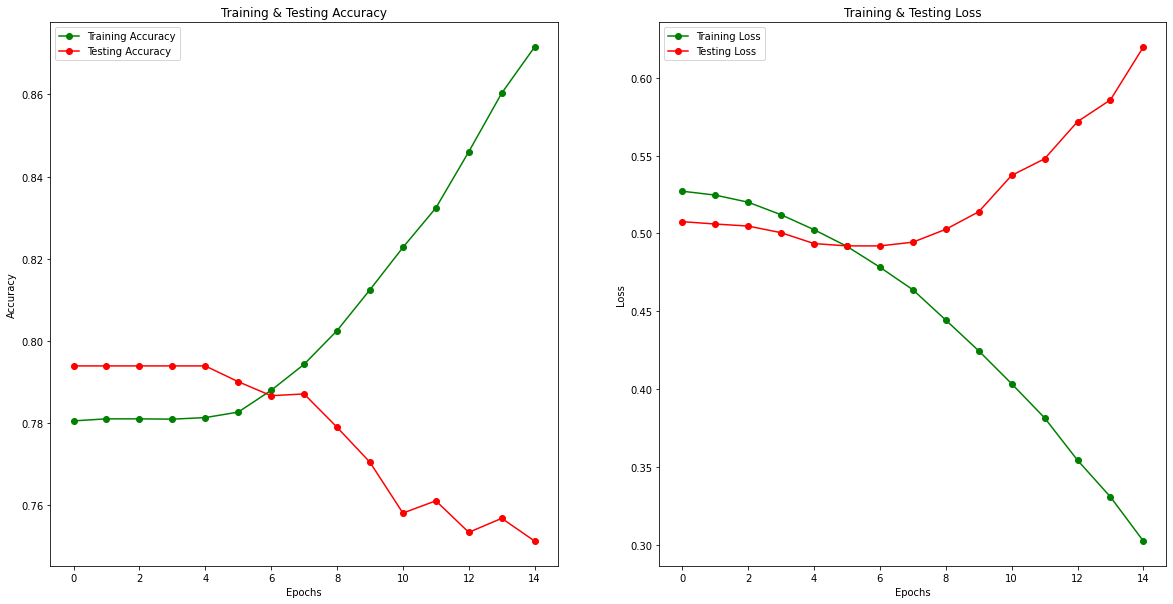

In [47]:


epochs = [i for i in range(15)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()



In [48]:
pred = model.predict(x_test)
pred[:5]

74/74 [==============================] - 13s 161ms/step


array([[0.16067739],
       [0.27189112],
       [0.02379198],
       [0.42174938],
       [0.23751807]], dtype=float32)

In [49]:
pred = np.round(pred).astype(int)
pred[:5]

array([[0],
       [0],
       [0],
       [0],
       [0]])

In [51]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,f1_score
print(classification_report(y_test, pred))


              precision    recall  f1-score   support

           0       0.80      0.88      0.84      1827
           1       0.37      0.24      0.29       531

    accuracy                           0.74      2358
   macro avg       0.58      0.56      0.56      2358
weighted avg       0.70      0.74      0.71      2358



In [52]:
print(confusion_matrix(y_test, pred))

[[1610  217]
 [ 406  125]]
